# CIFAR-10 Dataset: A Computer Vision Benchmark

## Overview
CIFAR-10 is a widely-used benchmark dataset in the field of computer vision and machine learning, specifically designed for object recognition tasks. Originally curated by researchers Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, it serves as a fundamental resource for developing and evaluating image classification algorithms.

## Dataset Specifications
- **Total Images**: 60,000 color images
- **Image Resolution**: 32x32 pixels
- **Format**: RGB color images
- **Split Distribution**:
  - Training set: 50,000 images (5,000 per class)
  - Testing set: 10,000 images (1,000 per class)

## Object Classes
The dataset contains exactly 10 distinct categories, with each image belonging to precisely one class:
1. Airplane
2. Automobile (excluding pickup trucks)
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck (excluding pickup trucks)

## Dataset Origins
CIFAR-10 represents a carefully curated subset of the larger "80 million tiny images" dataset. Its manageable size and well-balanced class distribution make it particularly suitable for:
- Prototyping new computer vision algorithms
- Educational purposes in machine learning courses
- Benchmarking classification models
- Testing deep learning architectures

## Historical Significance
The dataset has become a standard benchmark in the machine learning community, helping researchers and practitioners evaluate and compare different approaches to image classification since its release.

Will Cukierski. CIFAR-10 - Object Recognition in Images. https://kaggle.com/competitions/cifar-10, 2013. Kaggle.

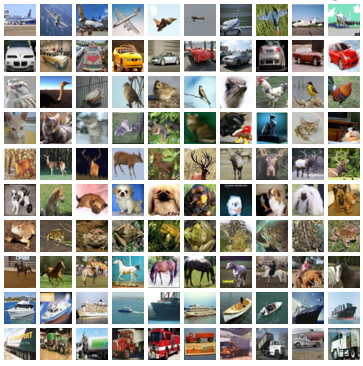


In [1]:
# Download with (x_train, y_train), (x_test, y_test) = cifar10.load_data() #was slow to download
# or 
# https://www.cs.toronto.edu/~kriz/cifar.html #as well was slow
# or 
# https://www.kaggle.com/competitions/cifar-10/data #faster, but filled with junk files in test (against cheating in the competition)

In [13]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
from functools import partial
import wget
import tarfile

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [14]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [15]:
object_mapping = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
}

In [16]:
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
RANDOM_SEED = 42

In [6]:
image_dir = r"datasets/train"
csv_path = r"datasets/trainLabels.csv"

In [7]:
labels_df = pd.read_csv(csv_path)
labels_df.sort_values(by="id", inplace=True)
labels_sorted = tf.convert_to_tensor(labels_df[["label"]], dtype=tf.string)

In [8]:
unique_labels = tf.convert_to_tensor(list(object_mapping.keys()), dtype=tf.string)

In [9]:
train_ids, val_ids, train_labels, val_labels = train_test_split(labels_df["id"], labels_df["label"], test_size=0.2, stratify=labels_df["label"], random_state=42)

In [10]:
train_ids = train_ids.values
val_ids = val_ids.values

In [11]:
@tf.function
def load_image(id):
    id_str = tf.strings.as_string(id)
    image_path = tf.strings.join([image_dir, '/', id_str, '.png'])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        
    label = tf.argmax(tf.equal(unique_labels, labels_sorted[id-1])) ##because index starts from 1 at pictures
    label = tf.cast(label, tf.float16)
    label = tf.reshape(label, [])
    
    return image, label

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.GaussianNoise(0.01),
])

In [13]:
@tf.function
def apply_data_augmentation(image, label):
    return data_augmentation(image), label

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
train_dataset = train_dataset.map(lambda id: load_image(id),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [15]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
val_dataset = val_dataset.map(lambda id: load_image(id), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
def configure_performance(ds, is_train_ds=True):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.map(apply_data_augmentation, 
                                  num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [17]:
train_dataset = configure_performance(train_dataset)
val_dataset = configure_performance(val_dataset, is_train_ds=False)

In [18]:
image_batch, labels_batch = next(iter(train_dataset))

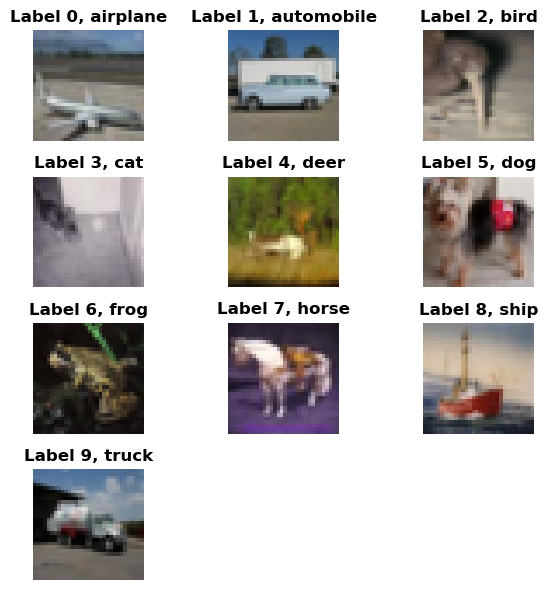

In [19]:
plt.figure(figsize=(6, 6))

for i in range(10):
  ax = plt.subplot(4, 3, i + 1)
  label_idx = tf.argmax(labels_batch.numpy() == i).numpy()
  plt.imshow(image_batch[label_idx])
  plt.title(f"Label {i}, {[objct for objct, value in object_mapping.items() if value ==i][0]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()


# Building a CNN with Sequential API

In [20]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay 
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule for custom scheduling

class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_target, warmup_steps, decay_steps, alpha=0.0):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_target = warmup_target
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha

    def __call__(self, step):
        warmup_lr = self.initial_learning_rate + (self.warmup_target - self.initial_learning_rate) * (step / self.warmup_steps)
        
        step_cosine = step - self.warmup_steps
        decay_steps_adjusted = self.decay_steps - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * step_cosine / decay_steps_adjusted))
        decayed_lr = (1 - self.alpha) * cosine_decay + self.alpha
        decayed_lr = self.warmup_target * decayed_lr

        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: decayed_lr
        )

In [21]:
# input=W, filter=F, padding=P, S=Stride, => (W−F+2P)/S+1

In [22]:
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),


    # Flatten and Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [23]:
lr_schedule = WarmupCosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=5000,
    decay_steps=62500,
    alpha=0.0
)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
)

Epoch 1/50
1250/1250 [==============================] - 61s 44ms/step - loss: 2.3899 - accuracy: 0.2115 - val_loss: 1.7002 - val_accuracy: 0.3762
Epoch 2/50
1250/1250 [==============================] - 28s 22ms/step - loss: 1.7043 - accuracy: 0.3774 - val_loss: 1.4483 - val_accuracy: 0.4930
Epoch 3/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.4743 - accuracy: 0.4715 - val_loss: 1.2313 - val_accuracy: 0.5590
Epoch 4/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.2843 - accuracy: 0.5470 - val_loss: 1.2250 - val_accuracy: 0.5573
Epoch 5/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1353 - accuracy: 0.6024 - val_loss: 0.9282 - val_accuracy: 0.6801
Epoch 6/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0000 - accuracy: 0.6546 - val_loss: 0.8388 - val_accuracy: 0.7111
Epoch 7/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9220 - accuracy: 0.6867 - val_loss: 1.0346 -

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                      

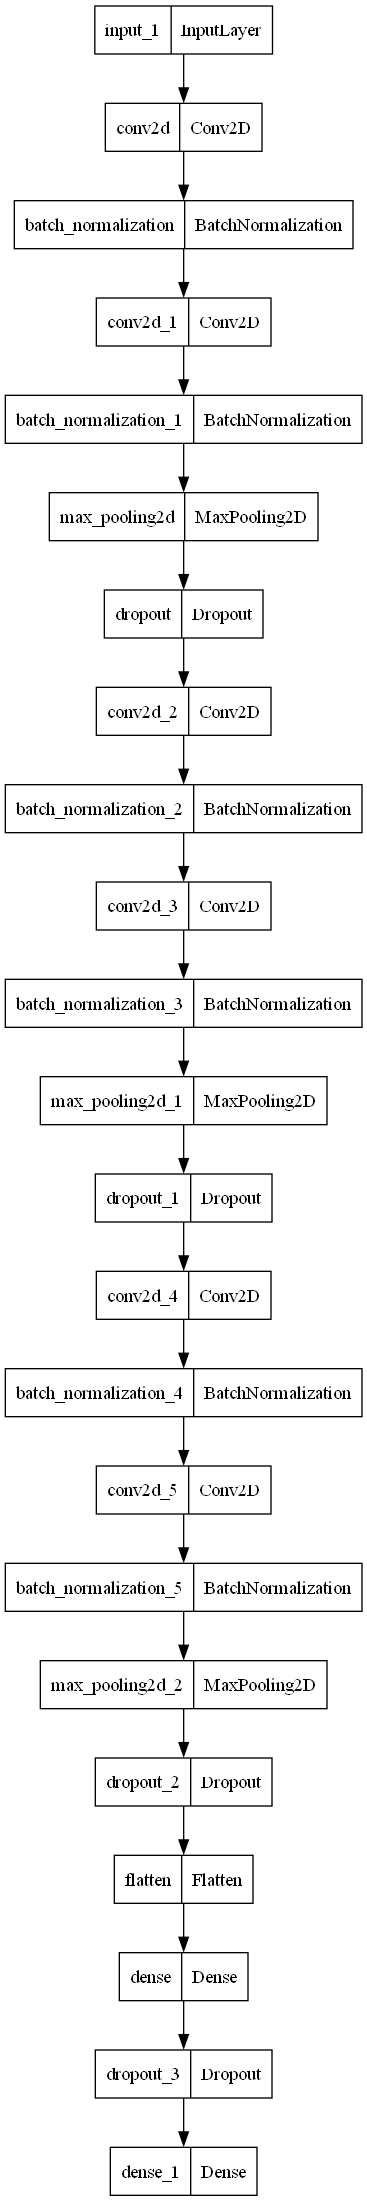

In [27]:
tf.keras.utils.plot_model(model)

In [28]:
def visualize_filter_responses(model, layer_index, input_image, nrows=int, ncols=int, figsize=(10, 6)):
    intermediate_model = tf.keras.Model(
        inputs=model.input, 
        outputs=model.layers[layer_index].output
    )
    
    responses = intermediate_model.predict(tf.expand_dims(input_image, 0))
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(min(64, responses.shape[-1])):
        row = i // 8
        col = i % 8
        axs[row, col].set_title(f"Filter:{i}")
        axs[row, col].imshow(responses[0, :, :, i], cmap='viridis')
        axs[row, col].axis('off')
        
    plt.suptitle(f"Convolution layer indexed: {layer_index} applied on a sample image")
    plt.tight_layout()
    plt.show()

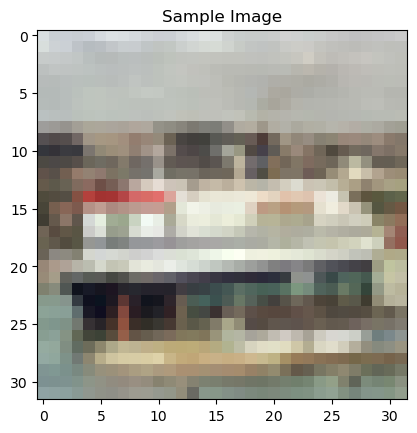

In [29]:
sample_image = next(iter(train_dataset))[0][0]
plt.title("Sample Image")
plt.imshow(sample_image)
plt.show()

1/1 [==============================] - 3s 3s/step


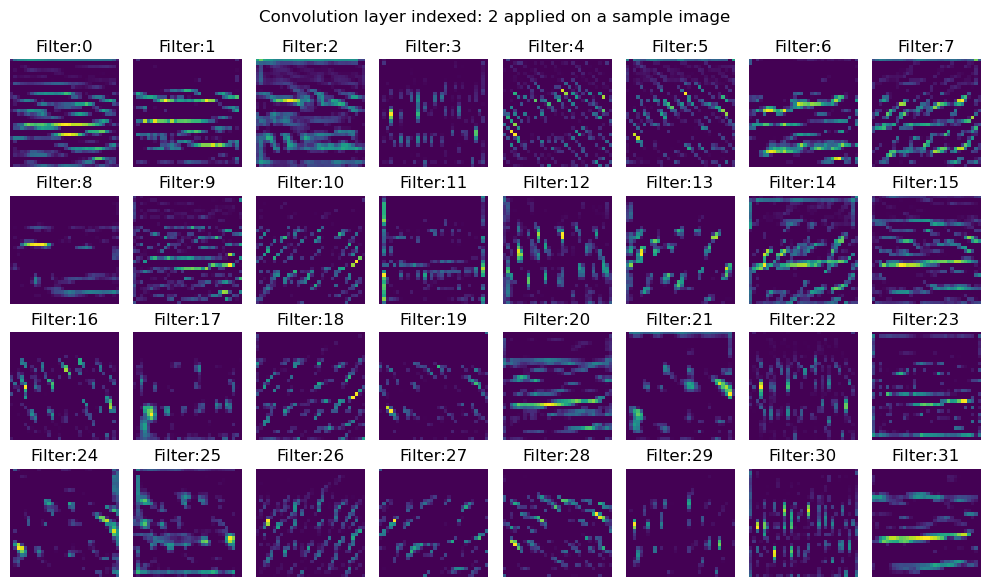

In [30]:
visualize_filter_responses(model, 2, sample_image, nrows=4, ncols=8)

1/1 [==============================] - 0s 332ms/step


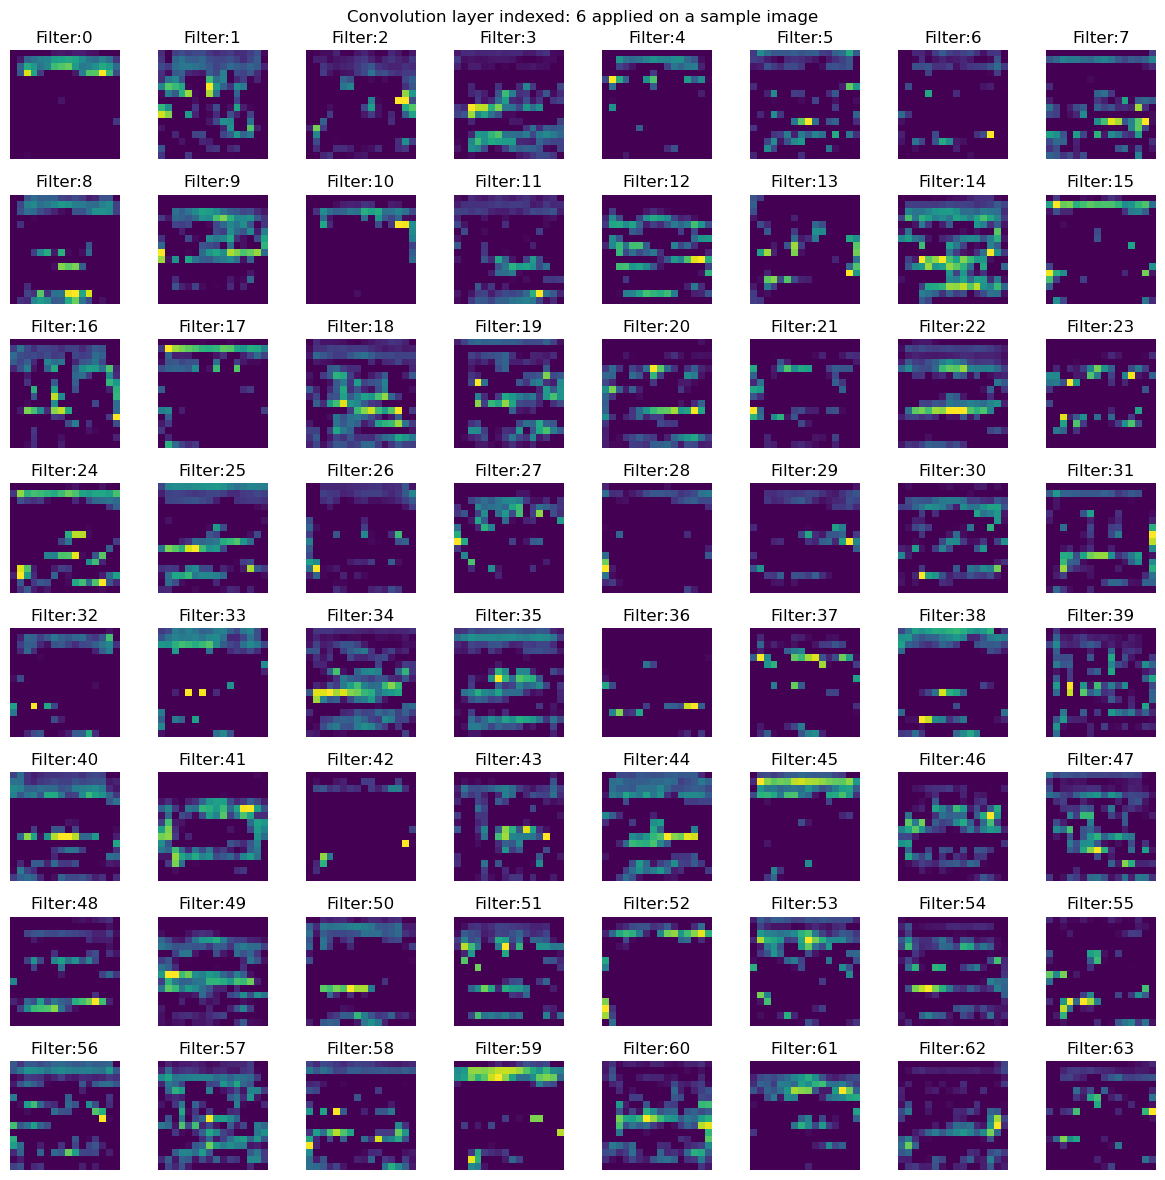

In [31]:
visualize_filter_responses(model, 6, sample_image, nrows=8, ncols=8, figsize=(12, 12))

In [32]:
predictions = model.predict(val_dataset)

313/313 [==============================] - 7s 11ms/step


In [33]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.float16)
prediction_confidence = tf.reduce_max(predictions, axis=1)

In [34]:
validation_imgs = []
actual_labels = []
for imgs, labels in val_dataset:
    validation_imgs.extend(imgs.numpy())
    actual_labels.extend(labels.numpy())

validation_imgs = tf.convert_to_tensor(validation_imgs)
actual_labels = tf.convert_to_tensor(actual_labels)

In [35]:
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)

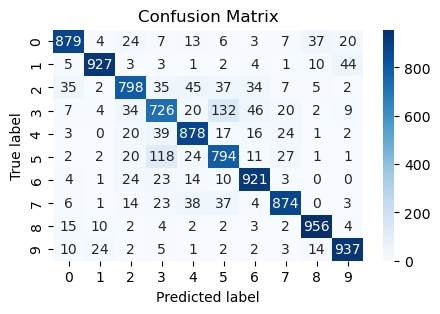

Validation Accuracy: 0.8690


In [36]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [37]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 10

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 0.9099
  Recall: 0.8790
  F1-score: 0.8942
Class 1:
  Precision: 0.9508
  Recall: 0.9270
  F1-score: 0.9387
Class 2:
  Precision: 0.8480
  Recall: 0.7980
  F1-score: 0.8223
Class 3:
  Precision: 0.7386
  Recall: 0.7260
  F1-score: 0.7322
Class 4:
  Precision: 0.8475
  Recall: 0.8780
  F1-score: 0.8625
Class 5:
  Precision: 0.7642
  Recall: 0.7940
  F1-score: 0.7788
Class 6:
  Precision: 0.8822
  Recall: 0.9210
  F1-score: 0.9012
Class 7:
  Precision: 0.9029
  Recall: 0.8740
  F1-score: 0.8882
Class 8:
  Precision: 0.9318
  Recall: 0.9560
  F1-score: 0.9437
Class 9:
  Precision: 0.9168
  Recall: 0.9370
  F1-score: 0.9268

Macro-average F1-score: 0.8689


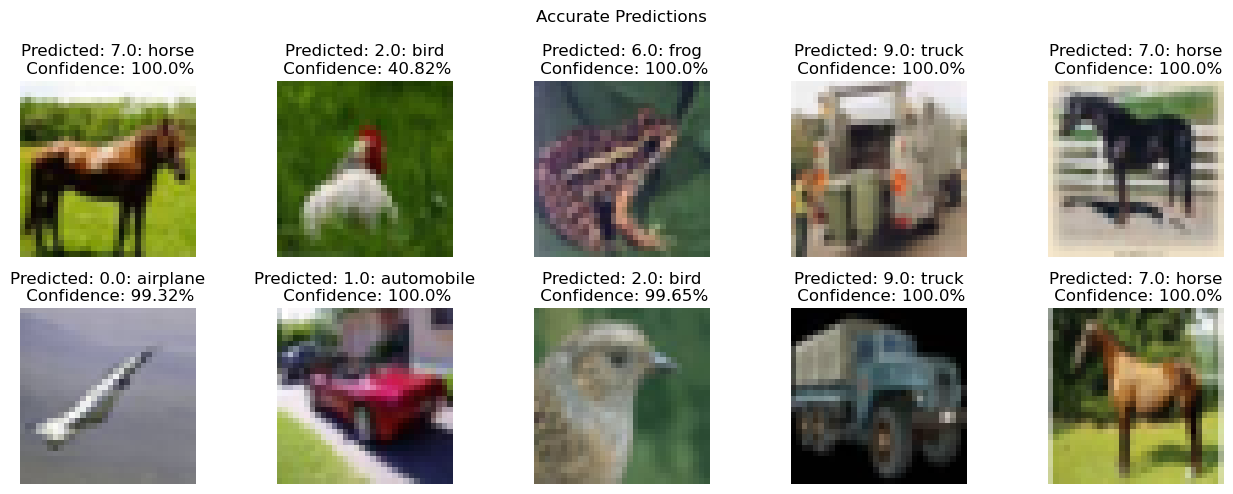

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels==actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted: {predicted_labels[random_index].numpy()}: {unique_labels[int(predicted_labels[random_index].numpy())].numpy().decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

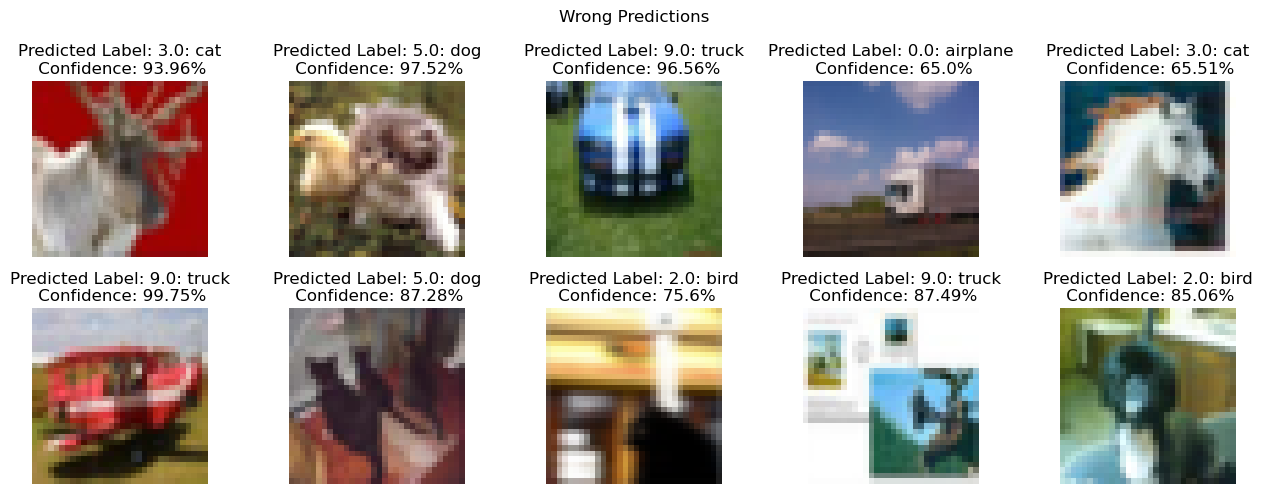

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Wrong Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels!=actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Label: {predicted_labels[random_index].numpy()}: {unique_labels[int(predicted_labels[random_index].numpy())].numpy().decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Cross Validation on 5 Stratified KFold

In [40]:
# Just for reproducibility purpose
random_splits_seeds = [10, 523, 3210, 5623113, 1244]

In [41]:
def return_model():
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    lr_schedule = WarmupCosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=5000,
    decay_steps=62500,
    alpha=0.0
    )

    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    
    return model

In [ ]:
accuracies = []
for random_state in random_splits_seeds:

    train_ids, val_ids, train_labels, val_labels = train_test_split(labels_df["id"], labels_df["label"], test_size=0.2, stratify=labels_df["label"], random_state=random_state)
    train_ids = train_ids.values
    val_ids = val_ids.values

    train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
    train_dataset = train_dataset.map(lambda id: load_image(id),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_dataset = train_dataset.map(apply_data_augmentation, 
                                    num_parallel_calls=tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
    val_dataset = val_dataset.map(lambda id: load_image(id), 
                        num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = configure_performance(train_dataset, is_train_ds=True)
    val_dataset = configure_performance(val_dataset, is_train_ds=False)

    model = return_model()

    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
    )
    
    predictions = model.predict(val_dataset)

    predicted_labels = tf.argmax(predictions, axis=1)
    predicted_labels = tf.cast(predicted_labels, tf.float16)

    actual_labels = []

    for _, labels in val_dataset:
        actual_labels.extend(labels.numpy())

    actual_labels = tf.convert_to_tensor(actual_labels)
    accuracy = accuracy_score(actual_labels, predicted_labels)
    print(f"Current Fold Accuracy: {round(accuracy, 4)}")
    accuracies.append(accuracy)    
    del val_dataset, model


In [43]:
print(f"5 Fold avg. accuracy: {round(np.mean(accuracies)*100, 2)}%")

5 Fold avg. accuracy: 86.49%


## Predict on test set

In [44]:
train_ids = labels_df.id.values
train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
train_dataset = train_dataset.map(lambda id: load_image(id),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.map(apply_data_augmentation, 
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = configure_performance(train_dataset)

In [45]:
model = return_model()
model.fit(
    train_dataset,
    epochs=50,
)

Epoch 1/50
1563/1563 [==============================] - 46s 27ms/step - loss: 2.3615 - accuracy: 0.2155
Epoch 2/50
1563/1563 [==============================] - 41s 26ms/step - loss: 1.6253 - accuracy: 0.4080
Epoch 3/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3617 - accuracy: 0.5143
Epoch 4/50
1563/1563 [==============================] - 27s 17ms/step - loss: 1.1504 - accuracy: 0.5998
Epoch 5/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0238 - accuracy: 0.6509
Epoch 6/50
1563/1563 [==============================] - 32s 20ms/step - loss: 0.9197 - accuracy: 0.6890
Epoch 7/50
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8442 - accuracy: 0.7127
Epoch 8/50
1563/1563 [==============================] - 31s 20ms/step - loss: 0.7838 - accuracy: 0.7368
Epoch 9/50
1563/1563 [==============================] - 33s 21ms/step - loss: 0.7321 - accuracy: 0.7557
Epoch 10/50
1563/1563 [==============================] - 32s 20m

In [46]:
# Import test img-s
image_dir = r"datasets/test"

In [47]:
@tf.function
def load_image_test(id):
    id_str = tf.strings.as_string(id)
    image_path = tf.strings.join([image_dir, '/', id_str, '.png'])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        
    return image

In [48]:
test_ids = np.arange(1, 300001)

In [49]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_ids)
test_dataset = test_dataset.map(lambda id: load_image_test(id), 
                        num_parallel_calls=tf.data.AUTOTUNE)

In [50]:
test_dataset = configure_performance(test_dataset, is_train_ds=False)

In [51]:
image_batch = next(iter(test_dataset))

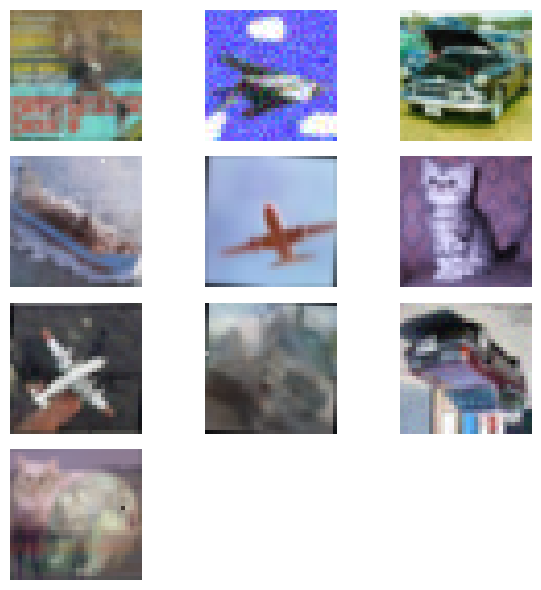

In [52]:
plt.figure(figsize=(6, 6))

for i in range(10):
  ax = plt.subplot(4, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.axis("off")

plt.tight_layout()


In [53]:
predictions = model.predict(test_dataset)

9375/9375 [==============================] - 142s 15ms/step


In [54]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.int32)

In [55]:
submission = pd.DataFrame(np.arange(1, 300001), columns=["id"])
submission["label"] = predicted_labels.numpy()

In [56]:
submission.replace({"label": dict(zip(object_mapping.values(), object_mapping.keys()))}, inplace=True)

In [57]:
submission.to_csv("submission.csv", index=False)